# Objective:
### 1) To find out significant variables required for the prediciton of house prices
### 2) Build a model using the variables

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
import statsmodels.api as sm

In [2]:
# Reading and viewing the data
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Total number of columns are 81
# Checking the value counts in the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Storing initial number of points
n_ini = len(data)

In [5]:
#  Form the data dictionary, the column id is irrelevant for prediction
data.drop("Id",inplace=True,axis=1)


In [6]:
# Some of the columns have many missing values which will not help in building the model
# Deleting the columns having more than 30% of missing values
remo_col=[]
for col in data.columns:
    if data[col].isna().sum() > 0.7* len(data):
        data.drop(col,inplace=True,axis=1)
        remo_col.append(col)
print("The number of columns removed are: ",len(remo_col))
print(remo_col)

The number of columns removed are:  4
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [7]:
# Removing columns having a single value occuring more than 70% of times
single_rep_col = []
for col in data.columns:
    if data[col].dtypes == np.object:
        if (data[col].value_counts(normalize=True).values)[0]>=0.7:
            single_rep_col.append(col)
            data.drop(col,inplace=True,axis=1)
print("The number of columns removed are: ",len(single_rep_col))
print(single_rep_col)

The number of columns removed are:  23
['MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [8]:
# Checking columns having missing values in data
mis_col=[]
for col in data.columns:
    if not(data[col].isna().sum() == 0):
        mis_col.append(col)
print("The number of columns having missing columns: ",len(mis_col))
print(mis_col)


The number of columns having missing columns:  10
['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish']


In [9]:
#  Missing value imputation
#  Filling the missing values with median if the column is numeric and with mode if the column is categorical
for miscol in mis_col:
    if data[miscol].dtype == np.object:
        data[miscol].fillna(data[miscol].value_counts().values[0],inplace=True)
    else:
        data[miscol].fillna(data[miscol].median(),inplace=True)


In [10]:
# Sorting the data based on data type
cat_data=data.loc[:,(data.dtypes == object).values]
num_data= data.loc[:,~(data.dtypes == object).values]

In [11]:
# Sorting the columns based on datatypes
num_columns = list(num_data.columns)
cat_columns = list(cat_data.columns)

In [12]:
# Class for EDA
class EDA:

    def dist_plot(self,data,feat): # method for dist plot
        plt.figure(figsize=(30,20))
        plt.subplots_adjust(hspace=0.5)
        n_rows = math.ceil(len(feat)/3)
        for n,i in enumerate(feat):
            plt.subplot(n_rows, 3, n + 1)
            sns.distplot(data[i],bins=50)
            # plt.xlabel(i,fontsize=12)
            # plt.ylabel("Density",fontsize=12)
            # plt.xticks(fontsize=12)
            # plt.yticks(fontsize=12)
        plt.show()

    def bar_plot(self,data,feat):
        plt.figure(figsize=(30,20))
        plt.subplots_adjust(hspace=0.5)
        n_rows = math.ceil(len(feat)/3)
        for n,i in enumerate(feat):
            plt.subplot(n_rows, 3, n + 1)
            axes = sns.barplot(x=i,y="SalePrice",data=data,estimator=np.median,ci=None)
        plt.show()

    def scatter_plot(self,data,feat):
        plt.figure(figsize=(30,20))
        n_rows = math.ceil(len(feat)/3)
        plt.subplots_adjust(hspace=0.7)
        for n,i in enumerate(feat):
            plt.subplot(n_rows, 3, n + 1)
            plt.scatter(data[i],data["SalePrice"])
            plt.xlabel(i,fontsize=12)
            plt.ylabel("SalePrice",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
        plt.show()

    def box_plot(self,data,feat):
        plt.figure(figsize=(30,20))
        plt.subplots_adjust(hspace=0.7)
        n_rows = math.ceil(len(feat)/3)
        for n,col in enumerate(feat):
            plt.subplot(n_rows,3,n+1)
            sns.boxplot(data[col])
        plt.show()  

    def remove_outliers(self,data, feat):
        quar1 = data[feat].quantile(0.95)
        quar3 = data[feat].quantile(0.05)
        iqr = quar3-quar1 
        low  = quar1
        high = quar3
        out_df = data.loc[(data[feat] > low) & (data[feat] < high)]
        return out_df

    


In [13]:
eda = EDA()

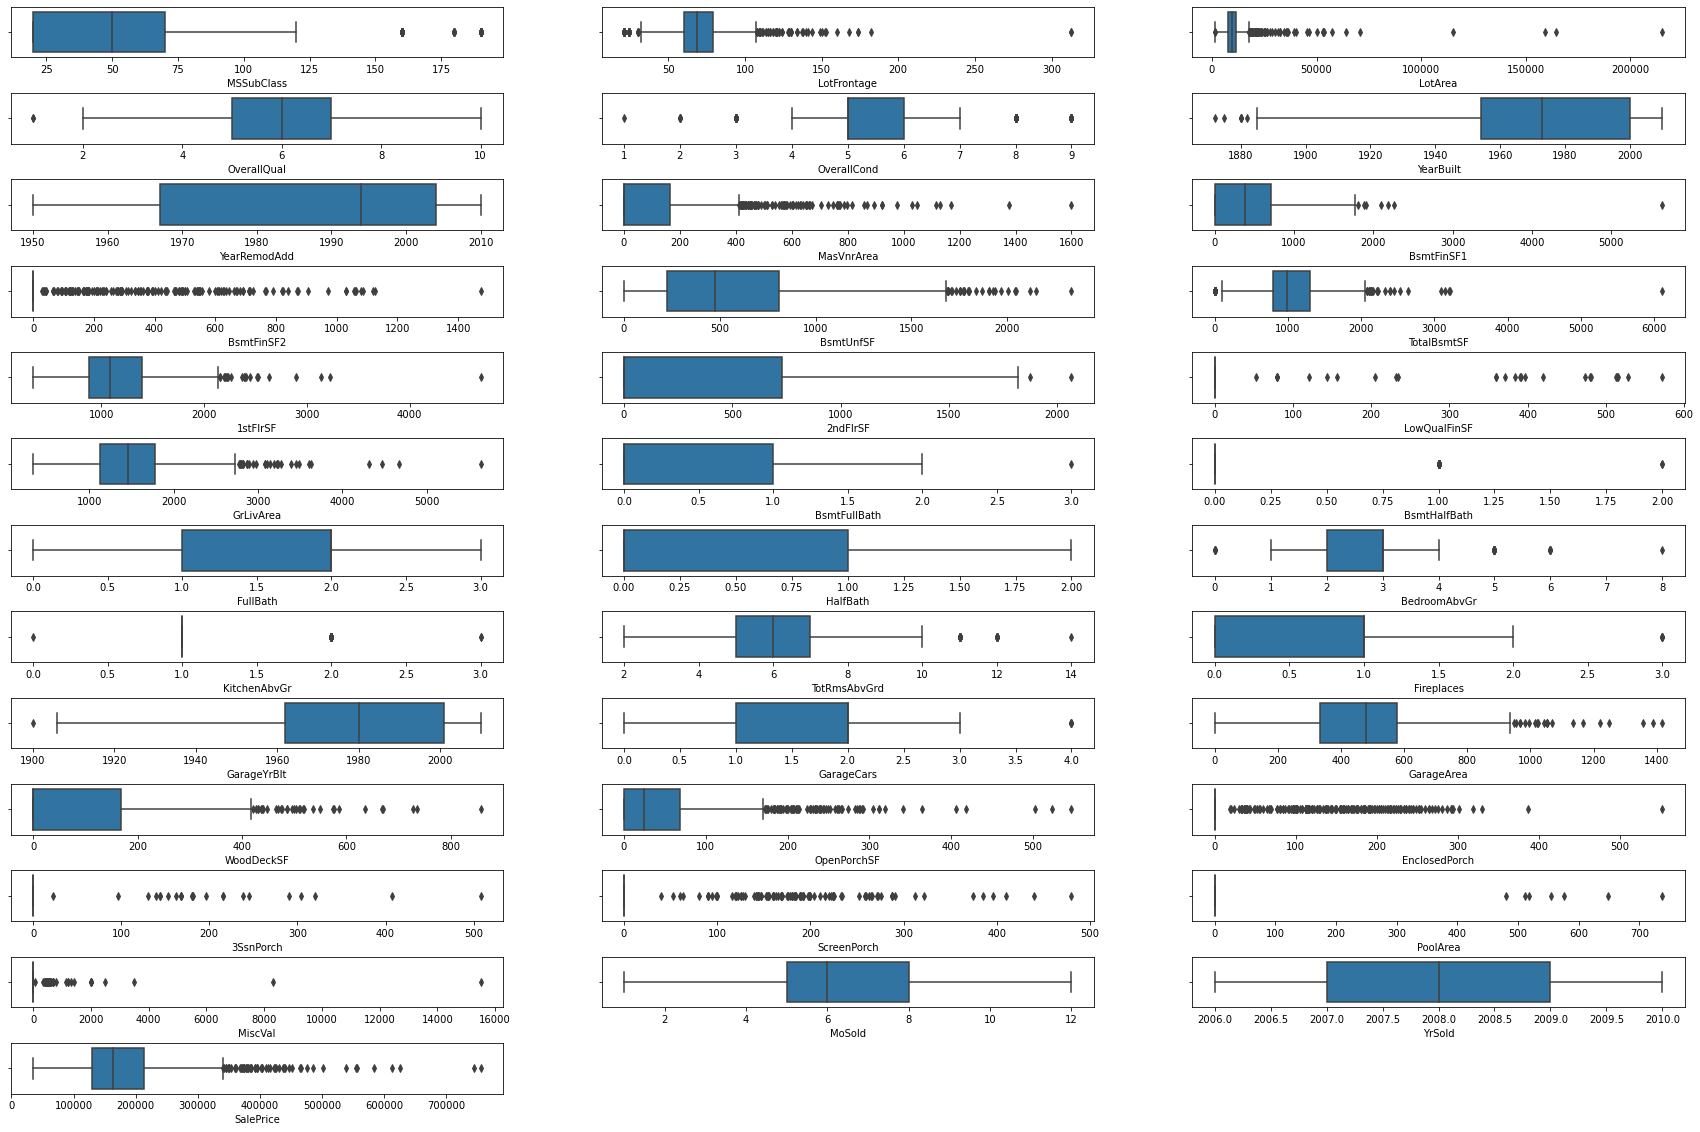

In [14]:
# Box plot
# Univariate analysis
eda.box_plot(data,num_columns)

In [15]:
# There are some features for which most of the values are 0
# Removing such features
removed_features = ["KitchenAbvGr","3SsnPorch","PoolArea","ScreenPorch","BsmtHalfBath","BsmtFinSF2","LowQualFinSF","MiscVal","EnclosedPorch"]
for feat in removed_features:
    num_columns.remove(feat)
data.drop(removed_features,inplace=True,axis=1)

In [16]:
# Removing outliers only for target variables considering the number of data points 
data = data[data["SalePrice"]<350000]
print("The number of points removed are :",n_ini-len(data))

The number of points removed are : 56


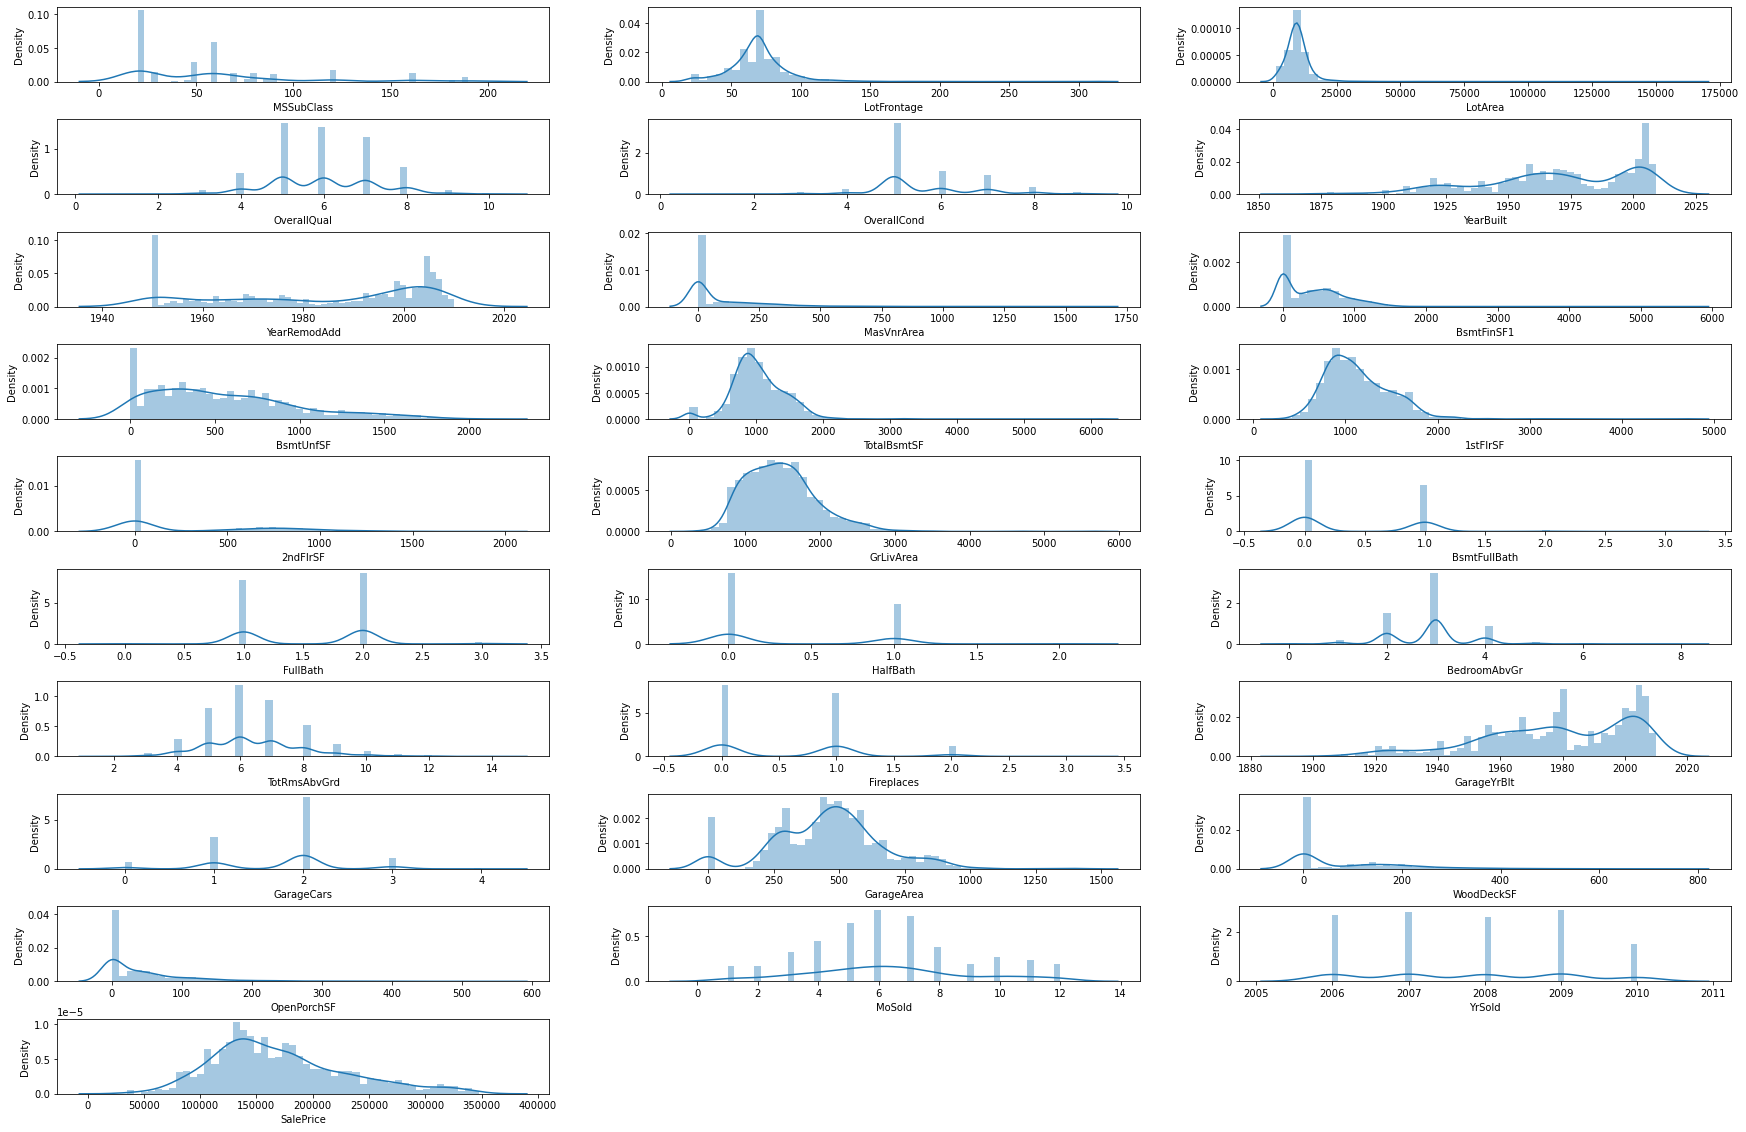

In [17]:
eda.dist_plot(data,num_columns)

In [18]:
# EDA insights
# Overall quality of most of the houses is > 5
# GrLivArea is following near normal distribution
# Most of the houses have 2 Garage cars
# For most of the houses the garage area is 500
# For most of the houses the total bsmt sft is 1000

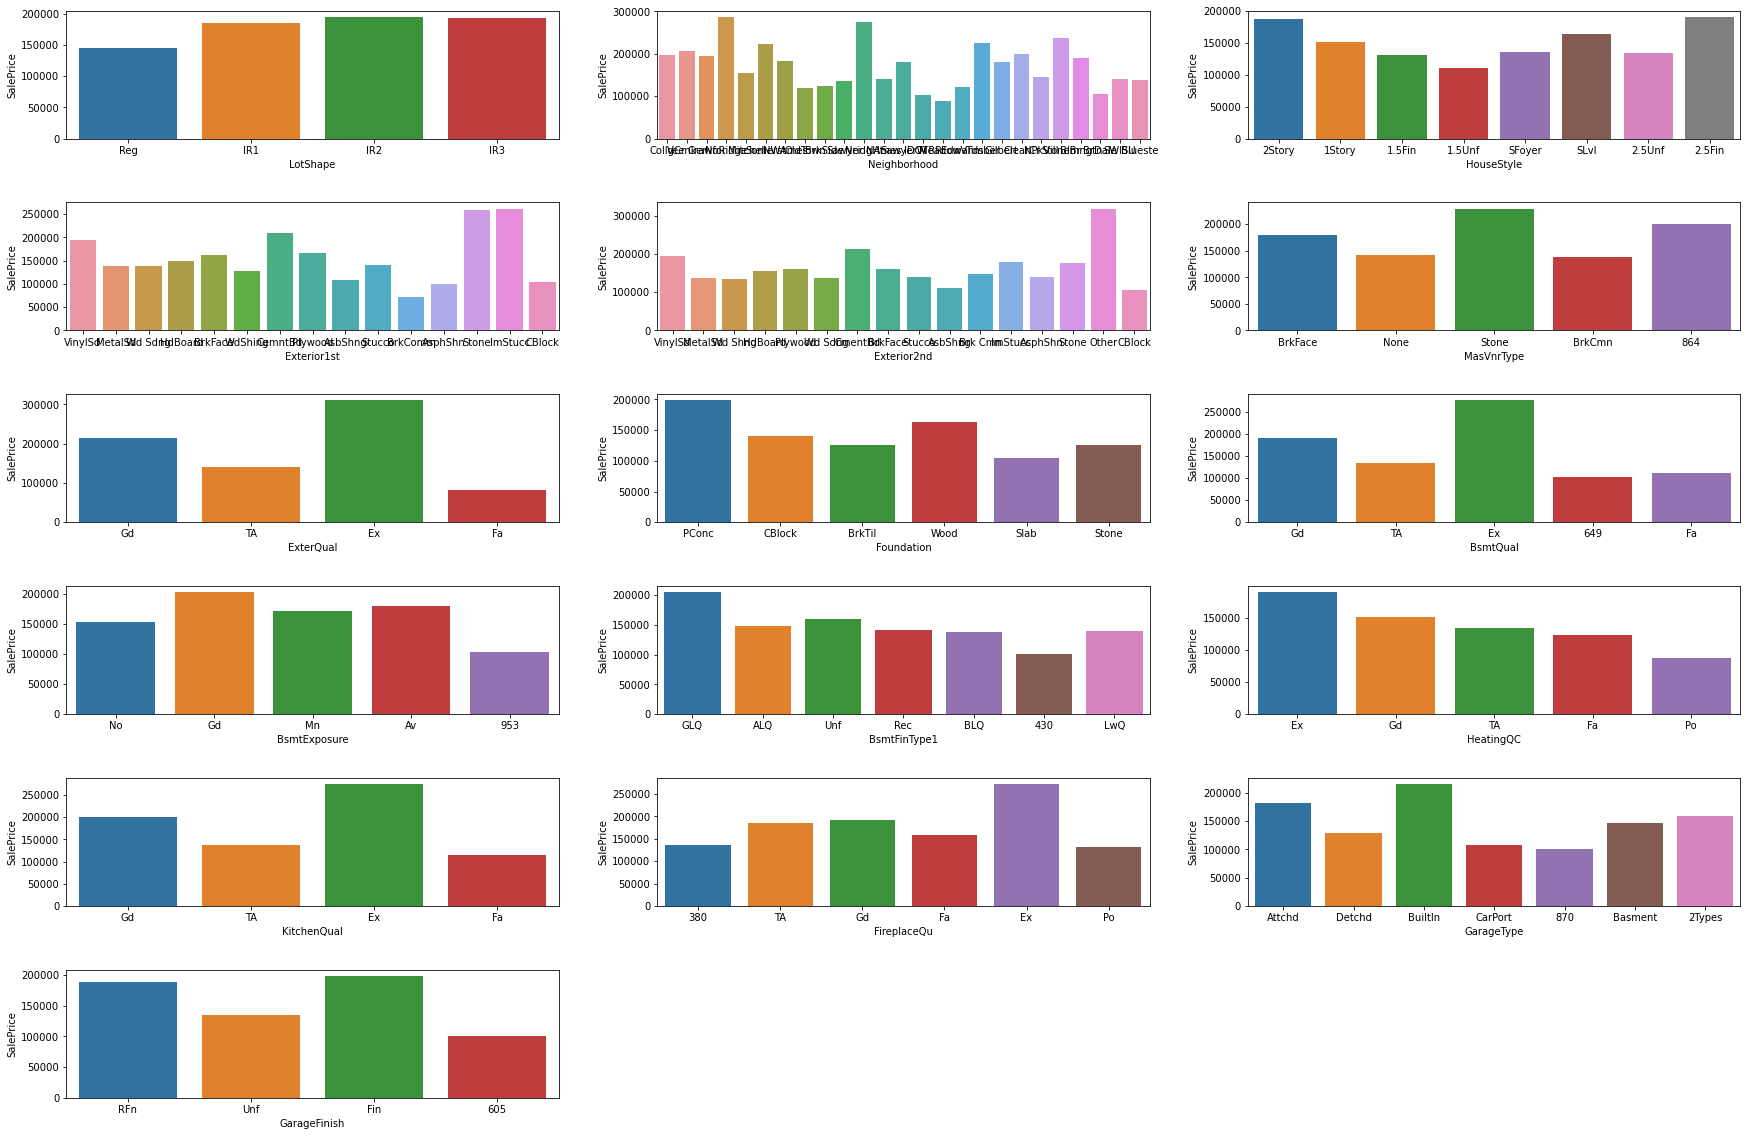

In [19]:
# Bivariate analysis
eda.bar_plot(data,cat_columns)

In [20]:
#  From the bar plots we can infer that
#  If the external quality,kitchen quality and basement quality is excellent then the avg sale price is more
#  The saleprice is more for finished garages
#  If the masonary veener type is stone the sale price is more

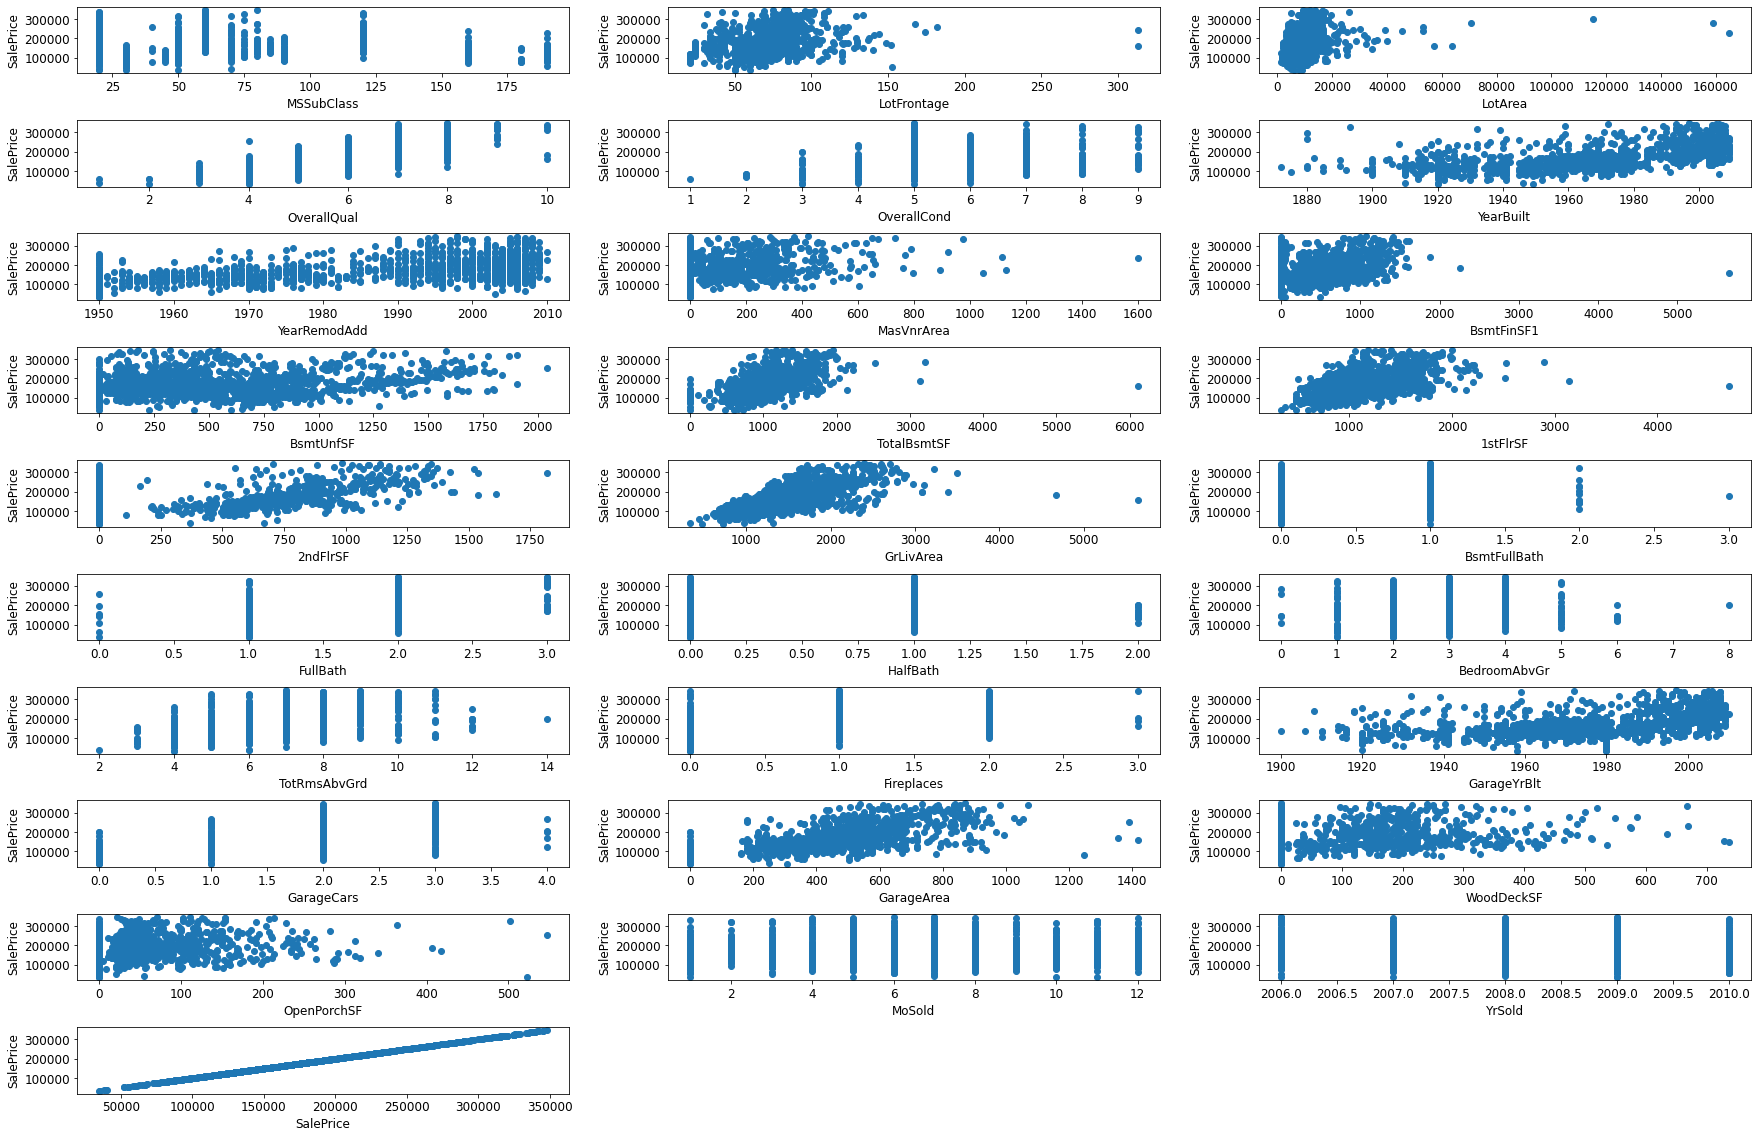

In [21]:
# Scatter plot between numerical variables
eda.scatter_plot(data,num_columns)

In [22]:
# From the scatter plot we can see linear relationship between our some variables such as GrLivArea,1stfloorSF etc and SalePrice

<AxesSubplot:>

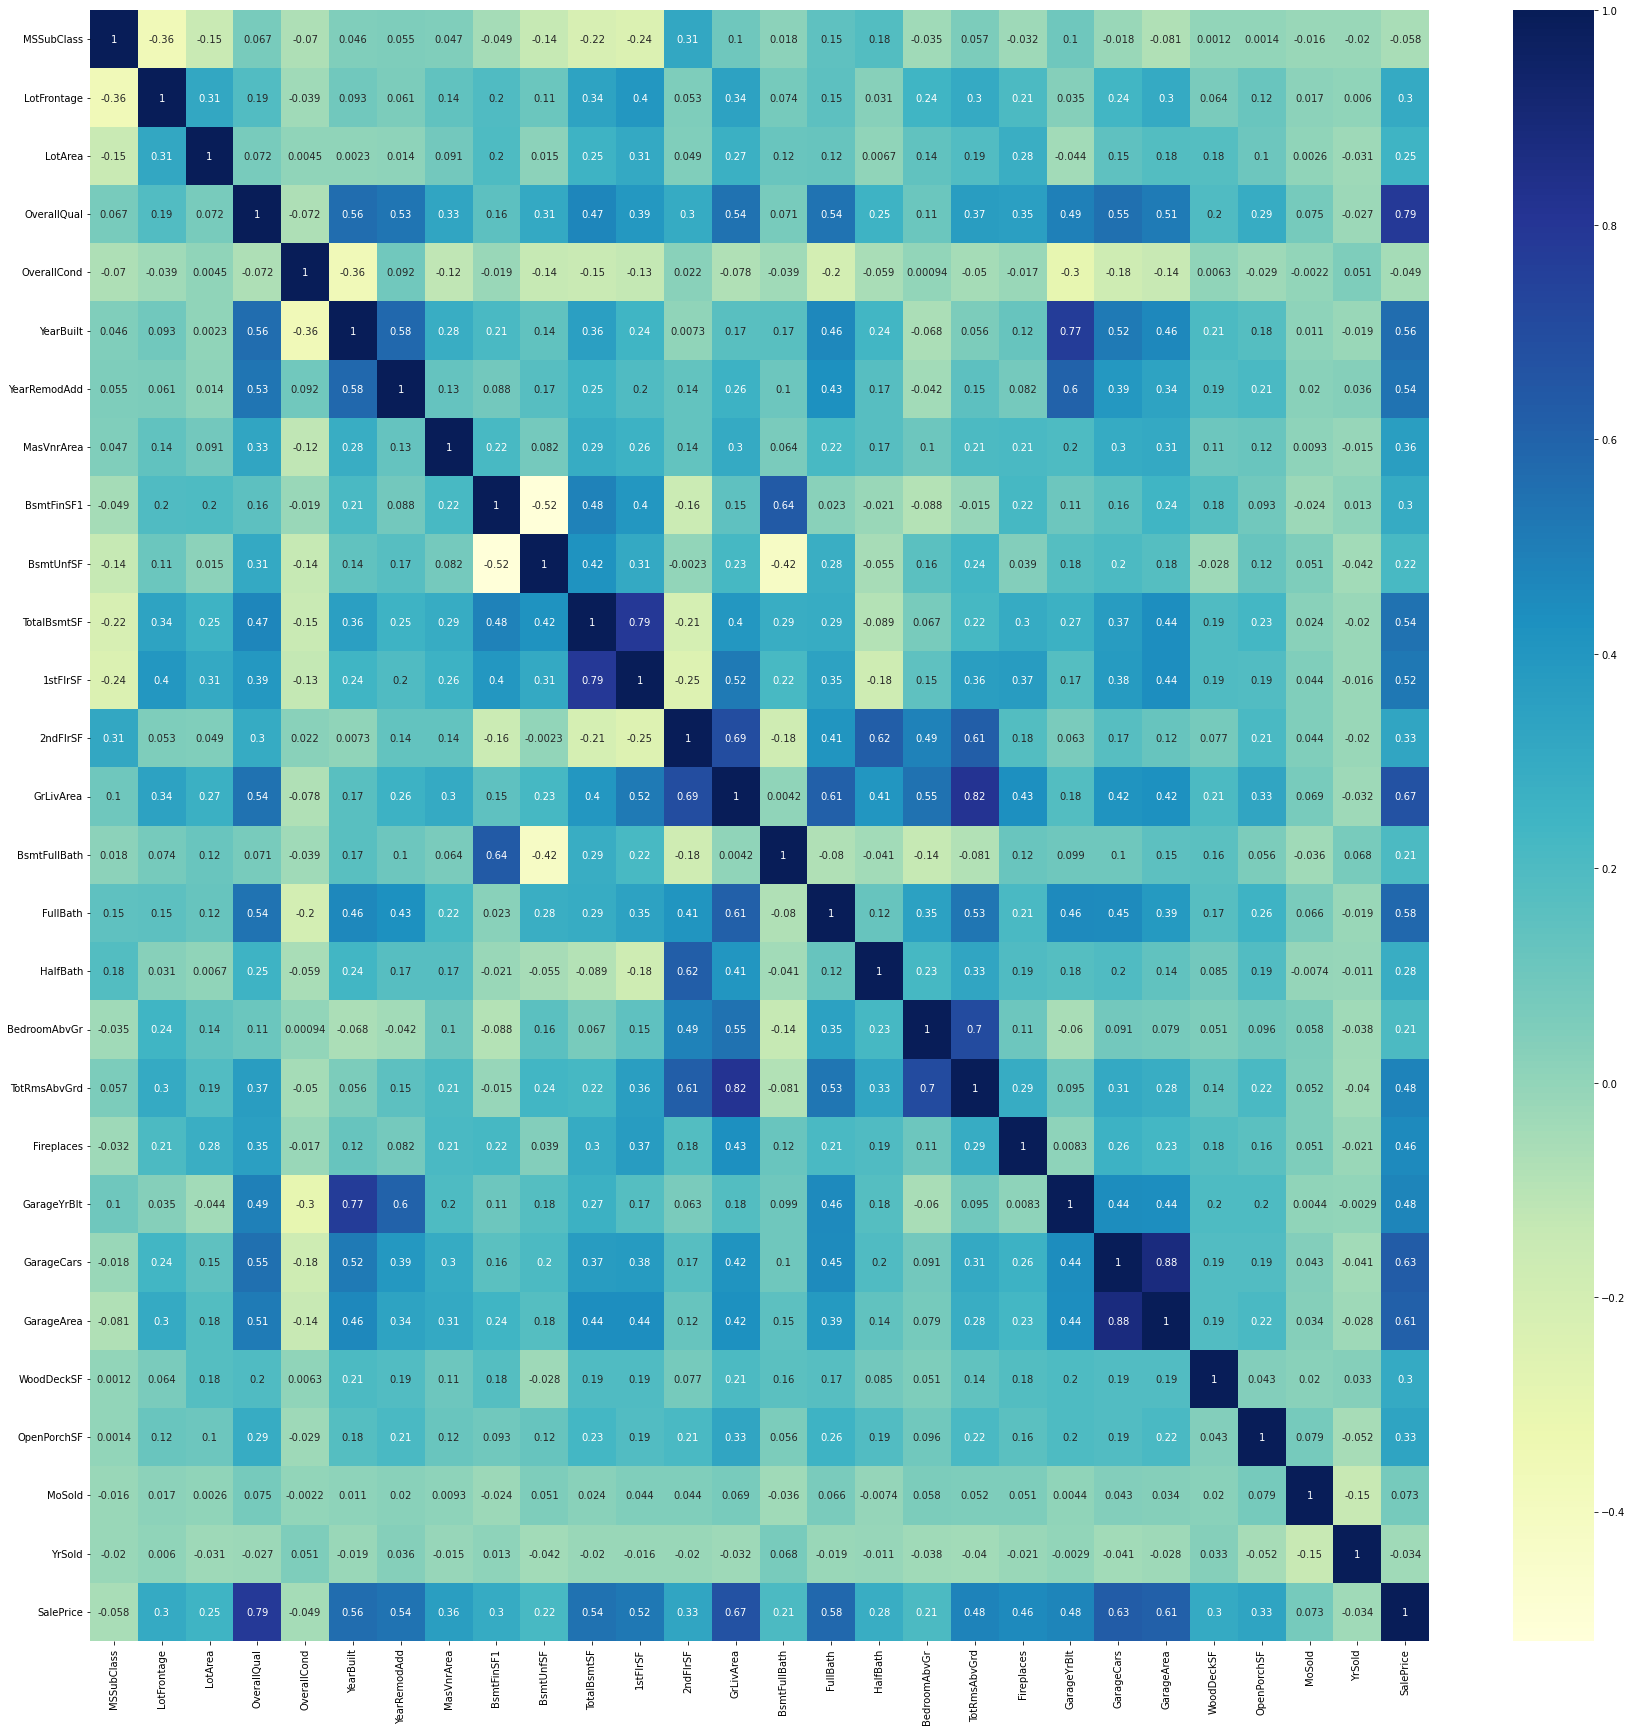

In [23]:
# Plotting corelation matrix between variables - bivariate analysis
corr_mat = data.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_mat,annot=True,cmap="YlGnBu")

In [24]:
# From the heatmap we can see that the following inputs are corelated
# So dropping them
# 1) GarageYrBlt - YearBuilt
# 2) 1stFlrSF - TotalBsmtSF
# 3) TotRmsAbvGrd - GrLivArea
# 4) GarageArea - GarageCars
data.drop(["GarageYrBlt","1stFlrSF","TotRmsAbvGrd","GarageArea"],axis=1,inplace=True)

In [25]:
#  Dummy encoding for categorical variables
data = pd.get_dummies(data,drop_first=True)

In [26]:
#  From the heatmap it can be seen that from the list of features the top correlated variables with SalePrice are
#  1) GarageCars
#  2) GrLivArea
#  3) TotalBsmtSF

In [27]:
# Class for model building
class model_build:
    
    def __init__(self,input_data,feat,target): # Instance attributes
        self.data = input_data
        self.X = feat
        self.y = target
    
    def split_data(self,test_ratio): # Method for splitting the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data[self.X], self.data[self.y], test_size=test_ratio, random_state=42)
    
    def perform_scaling(self): # Method for scaling the data using Min max scaler
        self.scaler = StandardScaler()
        self.X_train = pd.DataFrame(self.scaler.fit_transform(self.X_train),columns=self.X_train.columns)
        self.X_test = pd.DataFrame(self.scaler.transform(self.X_test),columns=self.X_test.columns)

    def perform_rfe(self,n_sel_feat): # Method for performing RFE
        self.rfe_model = LinearRegression()
        self.rfe = RFE(self.rfe_model,n_sel_feat)
        self.rfe.fit(self.X_train,self.y_train)
        self.X_train = self.X_train.loc[:,self.rfe.get_support()]
        self.X_test = self.X_test.loc[:,self.rfe.get_support()]
    
    def perform_ridge(self,grid): # Method for training ridge model
        self.ridgemodel = Ridge(random_state=42)
        self.ridge = GridSearchCV(self.ridgemodel,param_grid=grid,scoring="neg_mean_absolute_error",cv=5)
        self.ridge.fit(self.X_train,self.y_train)
        print("The best value of alpha found is : ",self.ridge.best_params_)
        self.ridge_train_pred = self.ridge.predict(self.X_train)
        self.ridge_test_pred = self.ridge.predict(self.X_test)
        self.ridge_trscore = r2_score(self.ridge_train_pred,self.y_train)
        self.ridge_tescore = r2_score(self.ridge_test_pred,self.y_test)
        print("The R2 on the train set is : ",self.ridge_trscore)
        print("The R2 on the test set is : ",self.ridge_tescore)

    def perform_lasso(self,grid): # Method for training lasso model
        self.lassomodel = Lasso(random_state=42)
        self.lasso = GridSearchCV(self.lassomodel,param_grid=grid,scoring="neg_mean_absolute_error",cv=5)
        self.lasso.fit(self.X_train,self.y_train)
        self.lassoselfeat = list(self.X_train.loc[:,np.array(self.lasso.best_estimator_.coef_,dtype=bool)].columns)
        print("The best value of alpha found is : ",self.lasso.best_params_)
        self.lasso_train_pred = self.lasso.predict(self.X_train)
        self.lasso_test_pred = self.lasso.predict(self.X_test)
        self.lasso_trscore = r2_score(self.lasso_train_pred,self.y_train)
        self.lasso_tescore = r2_score(self.lasso_test_pred,self.y_test)
        print("The R2 on the train set is : ",self.lasso_trscore)
        print("The R2 on the test set is : ",self.lasso_tescore)

    
    def calc_vif(self): # Method to calculate VIF
        sel_feat = list(self.X_train.columns)
        if len(sel_feat)<=1:
            print("Cannot calculate VIF as only one feature is present")
        else:
            self.vif_data = pd.DataFrame()
            self.vif_data["Features"]=sel_feat
            self.vif_data["VIF_values"] =  [variance_inflation_factor(self.X_train[sel_feat].values, i) for i in range(len(sel_feat))]
            self.vif_data = self.vif_data.sort_values(by="VIF_values",ascending=False)
            print(self.vif_data)

    def calc_sig(self): # Method to train the model using stats mod library
        stats_X_train = self.X_train.copy()
        stats_X_train["cnst"] = 1
        model = sm.OLS(self.y_train.values.reshape(-1,1),stats_X_train)
        trained_model = model.fit()
        print(trained_model.summary())



In [43]:
# Building the model
X = list(data.columns) # input features
X.remove("SalePrice")
y=["SalePrice"] # target variable
grid = {"alpha": list(np.arange(0.001,1010,10))}
model = model_build(data,X,y)

In [44]:
# Data splitting
model.split_data(0.3)

In [45]:
# Scaling the data using min-max scaler
model.perform_scaling()

In [46]:
# Performing RFE to get top 25 features
model.perform_rfe(15)
print("The features that are selected are :", model.X_train.columns)

The features that are selected are : Index(['MSSubClass', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces',
       'GarageCars', 'ExterQual_Gd', 'BsmtQual_Ex', 'BsmtQual_Gd',
       'BsmtQual_TA', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf',
       'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf'],
      dtype='object')


In [47]:
model.calc_sig()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     288.7
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:26:42   Log-Likelihood:                -11374.
No. Observations:                 982   AIC:                         2.278e+04
Df Residuals:                     966   BIC:                         2.286e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
MSSubClass       -6891.6644    871.375  

In [48]:
model.calc_vif()

            Features  VIF_values
13  GarageFinish_RFn    7.704197
14  GarageFinish_Unf    7.570070
12  GarageFinish_Fin    6.777618
8        BsmtQual_Gd    6.338970
9        BsmtQual_TA    4.982251
1        OverallQual    2.896827
7        BsmtQual_Ex    2.673052
5         GarageCars    2.453759
6       ExterQual_Gd    1.897297
10  BsmtFinType1_GLQ    1.831971
3          GrLivArea    1.710689
11  BsmtFinType1_Unf    1.368834
4         Fireplaces    1.335090
2        OverallCond    1.144398
0         MSSubClass    1.090196


In [49]:
# Removing GarageFinish_Fin as it is insignificant
model.X_train.drop(["GarageFinish_Fin"],axis=1,inplace=True)
model.X_test.drop(["GarageFinish_Fin"],axis=1,inplace=True)
model.calc_sig()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     308.7
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:26:48   Log-Likelihood:                -11375.
No. Observations:                 982   AIC:                         2.278e+04
Df Residuals:                     967   BIC:                         2.285e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
MSSubClass       -6825.7870    871.035  

In [50]:
model.calc_vif()

            Features  VIF_values
8        BsmtQual_Gd    6.325395
9        BsmtQual_TA    4.971971
1        OverallQual    2.868747
7        BsmtQual_Ex    2.671114
13  GarageFinish_Unf    2.041104
6       ExterQual_Gd    1.894510
10  BsmtFinType1_GLQ    1.830381
5         GarageCars    1.739728
3          GrLivArea    1.690839
12  GarageFinish_RFn    1.602531
11  BsmtFinType1_Unf    1.361540
4         Fireplaces    1.312267
2        OverallCond    1.138247
0         MSSubClass    1.087682


In [51]:
# Removing GarageFinish_RFn as it is insignificant
model.X_train.drop("GarageFinish_RFn",axis=1,inplace=True)
model.X_test.drop("GarageFinish_RFn",axis=1,inplace=True)
model.calc_sig()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     332.7
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:26:53   Log-Likelihood:                -11375.
No. Observations:                 982   AIC:                         2.278e+04
Df Residuals:                     968   BIC:                         2.285e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
MSSubClass       -6817.5815    870.624  

In [52]:
model.calc_vif()

            Features  VIF_values
8        BsmtQual_Gd    6.325260
9        BsmtQual_TA    4.956611
1        OverallQual    2.867067
7        BsmtQual_Ex    2.644083
6       ExterQual_Gd    1.893980
10  BsmtFinType1_GLQ    1.826857
3          GrLivArea    1.683877
5         GarageCars    1.663329
12  GarageFinish_Unf    1.432484
11  BsmtFinType1_Unf    1.355386
4         Fireplaces    1.309568
2        OverallCond    1.137970
0         MSSubClass    1.087398


In [53]:
# Removing BsmtQual_Gd as it has high VIF
model.X_train.drop("BsmtQual_Gd",axis=1,inplace=True)
model.X_test.drop("BsmtQual_Gd",axis=1,inplace=True)
model.calc_sig()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     350.2
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:26:58   Log-Likelihood:                -11387.
No. Observations:                 982   AIC:                         2.280e+04
Df Residuals:                     969   BIC:                         2.286e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
MSSubClass       -6482.4786    877.961  

In [54]:
model.calc_vif()

            Features  VIF_values
1        OverallQual    2.703483
6       ExterQual_Gd    1.872103
9   BsmtFinType1_GLQ    1.790748
8        BsmtQual_TA    1.706852
3          GrLivArea    1.676072
5         GarageCars    1.649426
11  GarageFinish_Unf    1.405391
10  BsmtFinType1_Unf    1.353877
4         Fireplaces    1.308354
7        BsmtQual_Ex    1.198720
2        OverallCond    1.137464
0         MSSubClass    1.080578


In [55]:
# The selected features are significant and are independent of each other
# Total features selected are : 12

In [56]:
# Training ridge model
model.perform_ridge(grid)

The best value of alpha found is :  {'alpha': 10.001}
The R2 on the train set is :  0.7677339182424532
The R2 on the test set is :  0.7892395929382584


In [57]:
# # Training lasso model
model.perform_lasso(grid)
print("The features selected by lasso are :")
print(model.lassoselfeat)

The best value of alpha found is :  {'alpha': 50.001}
The R2 on the train set is :  0.7686689198754516
The R2 on the test set is :  0.7901416868008714
The features selected by lasso are :
['MSSubClass', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'ExterQual_Gd', 'BsmtQual_Ex', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'GarageFinish_Unf']
